# ASHRAE - Great Energy Predictor III


Our aim in this competition is to predict energy consumption of buildings.

There are 4 types of energy to predict:

 - 0: electricity
 - 1: chilledwater
 - 2: steam
 - 3: hotwater

Electricity and water consumption may have different behavior!
So I tried to separately train & predict the model.

I moved previous [ASHRAE: Simple LGBM submission](https://www.kaggle.com/corochann/ashrae-simple-lgbm-submission) kernel.

**[Update] I published "[Optuna tutorial for hyperparameter optimization](https://www.kaggle.com/corochann/optuna-tutorial-for-hyperparameter-optimization)" notebook.
Please also check it :)**

In [1]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm import tqdm_notebook as tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
import catboost as cb


In [2]:
# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16 or not. feather format does not support float16.
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# Fast data loading

This kernel uses the preprocessed data from my previous kernel, [
ASHRAE: feather format for fast loading](https://www.kaggle.com/corochann/ashrae-feather-format-for-fast-loading), to accelerate data loading!

In [3]:
#%%time
root = Path('../data')

train_df = pd.read_csv(root/'train.csv')
weather_train_df = pd.read_csv(root/'weather_train_tz_fix.csv')
building_meta_df = pd.read_csv(root/'building_metadata.csv')

nasa_weather_df=pd.read_csv(root/'nasa_weather.csv')


In [4]:
nasa_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17552 entries, 0 to 17551
Data columns (total 10 columns):
ALLSKY_SFC_LW_DWN    17552 non-null float64
ALLSKY_SFC_SW_DWN    17552 non-null float64
ALLSKY_TOA_SW_DWN    17552 non-null float64
CDD0                 17552 non-null float64
CDD10                17552 non-null float64
CLRSKY_SFC_SW_DWN    17552 non-null float64
HDD18_3              17552 non-null float64
T2M                  17552 non-null float64
Date                 17552 non-null object
site_id              17552 non-null int64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


In [5]:
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
#test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
weather_train_df['timestamp'] = pd.to_datetime(weather_train_df['timestamp'])
#weather_test_df['timestamp'] = pd.to_datetime(weather_test_df['timestamp'])

In [6]:
nasa_weather_df.rename(columns={'Date':'date'}, inplace=True)

In [7]:
nasa_weather_df['date']=pd.to_datetime(nasa_weather_df['date']).dt.date
weather_train_df['date'] = weather_train_df['timestamp'].dt.date

In [8]:
weather_train_df=weather_train_df.merge(nasa_weather_df, on=['site_id', 'date'], how='left')
weather_train_df.drop(columns='date',inplace=True)

In [9]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,ALLSKY_SFC_LW_DWN,ALLSKY_SFC_SW_DWN,ALLSKY_TOA_SW_DWN,CDD0,CDD10,CLRSKY_SFC_SW_DWN,HDD18_3,T2M
0,0,2015-12-31 19:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2015-12-31 20:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2015-12-31 21:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2015-12-31 22:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2015-12-31 23:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
train_df['date'] = train_df['timestamp'].dt.date
train_df['meter_reading_log1p'] = np.log1p(train_df['meter_reading'])

In [11]:
def plot_date_usage(train_df, meter=0, building_id=0):
    train_temp_df = train_df[train_df['meter'] == meter]
    train_temp_df = train_temp_df[train_temp_df['building_id'] == building_id]    
    train_temp_df_meter = train_temp_df.groupby('date')['meter_reading_log1p'].sum()
    train_temp_df_meter = train_temp_df_meter.to_frame().reset_index()
    fig = sns.lineplot(x='date', y='meter_reading_log1p', data=train_temp_df_meter)
    plt.show()

C:\Anaconda\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



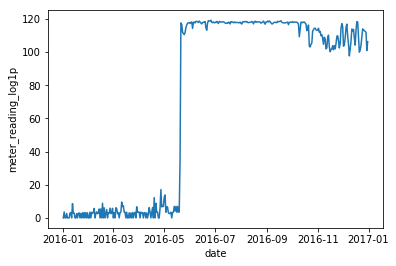

In [12]:
plot_date_usage(train_df, meter=0, building_id=1)

## Removing weired data on site_id 0

As you can see above, this data looks weired until May 20. It is reported in [this discussion](https://www.kaggle.com/c/ashrae-energy-prediction/discussion/113054#656588) by @barnwellguy that **All electricity meter is 0 until May 20 for site_id == 0**. I will remove these data from training data.

It corresponds to `building_id <= 104`.

In [13]:
building_meta_df[building_meta_df.site_id == 0]

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN
5,0,5,Education,8000,2000.0,NaN
6,0,6,Lodging/residential,27926,1981.0,NaN
7,0,7,Education,121074,1989.0,NaN
8,0,8,Education,60809,2003.0,NaN
9,0,9,Office,27000,2010.0,NaN


In [14]:
train_df = train_df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')

# Data preprocessing

Now, Let's try building GBDT (Gradient Boost Decision Tree) model to predict `meter_reading_log1p`. I will try using LightGBM in this notebook.

In [15]:
debug = False

# Add time feature

Some features introduced in https://www.kaggle.com/ryches/simple-lgbm-solution by @ryches

Features that are likely predictive:

#### Weather

- time of day
- holiday
- weekend
- cloud_coverage + lags
- dew_temperature + lags
- precip_depth + lags
- sea_level_pressure + lags
- wind_direction + lags
- wind_speed + lags


#### NASA Daily Average Weather

- T2M Temperature at 2 Meters (C) 
- ALLSKY_TOA_SW_DWN Top-of-atmosphere Insolation (kW-hr/m^2/day) 
- CDD10Cooling Degree Days Above 10 C (Degree C-d) 
- ALLSKY_SFC_LW_DWN Downward Thermal Infrared (Longwave) Radiative Flux (kW-hr/m^2/day) 
- ALLSKY_SFC_SW_DWN Sky Insolation Incident on a Horizontal Surface (kW-hr/m^2/day) 
- CDD0 Cooling Degree Days Above 0 C (Degree C-d) 
- HDD18_3 Heating Degree Days Below 18.3 C (Degree C-d) 
- CLRSKY_SFC_SW_DWN Clear Sky Insolation Incident on a Horizontal Surface (kW-hr/m^2/day) (MAINLY -999 will not be used)



#### Train

- max, mean, min, std of the specific building historically



However we should be careful of putting time feature, since we have only 1 year data in training,
including `date` makes overfiting to training data.

How about `month`? It may be better to check performance by cross validation.
I go not using this data in this kernel for robust modeling.

In [16]:
def preprocess(df):
    df["hour"] = df["timestamp"].dt.hour
#     df["day"] = df["timestamp"].dt.day
    df["weekend"] = df["timestamp"].dt.weekday
    df["month"] = df["timestamp"].dt.month
    df["dayofweek"] = df["timestamp"].dt.dayofweek

#     hour_rad = df["hour"].values / 24. * 2 * np.pi
#     df["hour_sin"] = np.sin(hour_rad)
#     df["hour_cos"] = np.cos(hour_rad)

In [17]:
preprocess(train_df)

In [18]:
df_group = train_df.groupby('building_id')['meter_reading_log1p']
building_mean = df_group.mean().astype(np.float16)
building_median = df_group.median().astype(np.float16)
building_min = df_group.min().astype(np.float16)
building_max = df_group.max().astype(np.float16)
building_std = df_group.std().astype(np.float16)

train_df['building_mean'] = train_df['building_id'].map(building_mean)
train_df['building_median'] = train_df['building_id'].map(building_median)
train_df['building_min'] = train_df['building_id'].map(building_min)
train_df['building_max'] = train_df['building_id'].map(building_max)
train_df['building_std'] = train_df['building_id'].map(building_std)

In [19]:
building_mean.head()

building_id
0    5.433594
1    4.761719
2    2.998047
3    5.875000
4    7.343750
Name: meter_reading_log1p, dtype: float16

# Fill Nan value in weather dataframe by interpolation


weather data has a lot of NaNs!!

![](http://)I tried to fill these values by **interpolating** data.

In [20]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,ALLSKY_SFC_LW_DWN,ALLSKY_SFC_SW_DWN,ALLSKY_TOA_SW_DWN,CDD0,CDD10,CLRSKY_SFC_SW_DWN,HDD18_3,T2M
0,0,2015-12-31 19:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2015-12-31 20:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2015-12-31 21:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2015-12-31 22:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2015-12-31 23:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# weather_train_df.describe()

In [22]:
weather_train_df.isna().sum()

site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
ALLSKY_SFC_LW_DWN        68
ALLSKY_SFC_SW_DWN        68
ALLSKY_TOA_SW_DWN        68
CDD0                     68
CDD10                    68
CLRSKY_SFC_SW_DWN        68
HDD18_3                  68
T2M                      68
dtype: int64

In [23]:
weather_train_df.shape

(139773, 17)

In [24]:
weather_train_df.groupby('site_id').apply(lambda group: group.isna().sum())

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,ALLSKY_SFC_LW_DWN,ALLSKY_SFC_SW_DWN,ALLSKY_TOA_SW_DWN,CDD0,CDD10,CLRSKY_SFC_SW_DWN,HDD18_3,T2M
site_id,,,,,,,,,,,,,,,,,
0,0,0,3,3830,3,1,85,250,0,5,5,5,5,5,5,5,5
1,0,0,1,7062,1,8763,52,3,0,0,0,0,0,0,0,0,0
2,0,0,1,2354,1,66,44,591,5,7,7,7,7,7,7,7,7
3,0,0,4,3642,6,37,158,153,4,5,5,5,5,5,5,5,5
4,0,0,0,4230,2,1317,73,105,0,7,7,7,7,7,7,7,7
5,0,0,2,6030,2,8755,8755,295,3,0,0,0,0,0,0,0,0
6,0,0,10,2992,10,0,175,779,39,4,4,4,4,4,4,4,4
7,0,0,0,8614,23,7883,8,0,0,5,5,5,5,5,5,5,5
8,0,0,3,3830,3,1,85,250,0,5,5,5,5,5,5,5,5


In [25]:
weather_train_df = weather_train_df.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))

In [26]:
weather_train_df.groupby('site_id').apply(lambda group: group.isna().sum())

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,ALLSKY_SFC_LW_DWN,ALLSKY_SFC_SW_DWN,ALLSKY_TOA_SW_DWN,CDD0,CDD10,CLRSKY_SFC_SW_DWN,HDD18_3,T2M
site_id,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,8763,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,8755,8755,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,8614,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Seems number of nan has reduced by `interpolate` but some property has never appear in specific `site_id`, and nan remains for these features.

## lags

Adding some lag feature

In [27]:
def add_lag_feature(weather_df, window=3):
    group_df = weather_df.groupby('site_id')
    cols = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
    rolled = group_df[cols].rolling(window=window, min_periods=0)
    lag_mean = rolled.mean().reset_index().astype(np.float16)
    lag_max = rolled.max().reset_index().astype(np.float16)
    lag_min = rolled.min().reset_index().astype(np.float16)
    lag_std = rolled.std().reset_index().astype(np.float16)
    for col in cols:
        weather_df[f'{col}_mean_lag{window}'] = lag_mean[col]
        weather_df[f'{col}_max_lag{window}'] = lag_max[col]
        weather_df[f'{col}_min_lag{window}'] = lag_min[col]
        weather_df[f'{col}_std_lag{window}'] = lag_std[col]

In [28]:
add_lag_feature(weather_train_df, window=3)
add_lag_feature(weather_train_df, window=72)

In [29]:
weather_train_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,ALLSKY_SFC_LW_DWN,...,sea_level_pressure_min_lag72,sea_level_pressure_std_lag72,wind_direction_mean_lag72,wind_direction_max_lag72,wind_direction_min_lag72,wind_direction_std_lag72,wind_speed_mean_lag72,wind_speed_max_lag72,wind_speed_min_lag72,wind_speed_std_lag72
0,0,2015-12-31 19:00:00,25.0,6.0,20.0,-1.0,1019.7,0.0,0.0,9.53,...,1019.5,NaN,0.000000,0.0,0.0,NaN,0.000000,0.000000,0.0,NaN
1,0,2015-12-31 20:00:00,24.4,4.0,21.1,-1.0,1020.2,70.0,1.5,9.53,...,1019.5,0.353516,35.000000,70.0,0.0,49.50000,0.750000,1.500000,0.0,1.060547
2,0,2015-12-31 21:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0,9.53,...,1019.5,0.288574,23.328125,70.0,0.0,40.40625,0.500000,1.500000,0.0,0.866211
3,0,2015-12-31 22:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0,9.53,...,1019.5,0.238037,17.500000,70.0,0.0,35.00000,0.375000,1.500000,0.0,0.750000
4,0,2015-12-31 23:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6,9.53,...,1019.5,0.207397,64.000000,250.0,0.0,108.31250,0.819824,2.599609,0.0,1.188477


In [30]:
weather_train_df.columns

Index(['site_id', 'timestamp', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed', 'ALLSKY_SFC_LW_DWN',
       'ALLSKY_SFC_SW_DWN', 'ALLSKY_TOA_SW_DWN', 'CDD0', 'CDD10',
       'CLRSKY_SFC_SW_DWN', 'HDD18_3', 'T2M', 'air_temperature_mean_lag3',
       'air_temperature_max_lag3', 'air_temperature_min_lag3',
       'air_temperature_std_lag3', 'cloud_coverage_mean_lag3',
       'cloud_coverage_max_lag3', 'cloud_coverage_min_lag3',
       'cloud_coverage_std_lag3', 'dew_temperature_mean_lag3',
       'dew_temperature_max_lag3', 'dew_temperature_min_lag3',
       'dew_temperature_std_lag3', 'precip_depth_1_hr_mean_lag3',
       'precip_depth_1_hr_max_lag3', 'precip_depth_1_hr_min_lag3',
       'precip_depth_1_hr_std_lag3', 'sea_level_pressure_mean_lag3',
       'sea_level_pressure_max_lag3', 'sea_level_pressure_min_lag3',
       'sea_level_pressure_std_lag3', 'wind_direction_mean_lag3',
       'wind

In [31]:
# categorize primary_use column to reduce memory on merge...

primary_use_list = building_meta_df['primary_use'].unique()
primary_use_dict = {key: value for value, key in enumerate(primary_use_list)} 
print('primary_use_dict: ', primary_use_dict)
building_meta_df['primary_use'] = building_meta_df['primary_use'].map(primary_use_dict)

gc.collect()

primary_use_dict:  {'Education': 0, 'Lodging/residential': 1, 'Office': 2, 'Entertainment/public assembly': 3, 'Other': 4, 'Retail': 5, 'Parking': 6, 'Public services': 7, 'Warehouse/storage': 8, 'Food sales and service': 9, 'Religious worship': 10, 'Healthcare': 11, 'Utility': 12, 'Technology/science': 13, 'Manufacturing/industrial': 14, 'Services': 15}


414

In [32]:
reduce_mem_usage(train_df, use_float16=True)
reduce_mem_usage(building_meta_df, use_float16=True)
reduce_mem_usage(weather_train_df, use_float16=True)

Memory usage of dataframe is 1857.04 MB
Memory usage after optimization is: 776.94 MB
Decreased by 58.2%
Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 74.9%
Memory usage of dataframe is 34.12 MB
Memory usage after optimization is: 21.19 MB
Decreased by 37.9%


,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,ALLSKY_SFC_LW_DWN,...,sea_level_pressure_min_lag72,sea_level_pressure_std_lag72,wind_direction_mean_lag72,wind_direction_max_lag72,wind_direction_min_lag72,wind_direction_std_lag72,wind_speed_mean_lag72,wind_speed_max_lag72,wind_speed_min_lag72,wind_speed_std_lag72
0,0,2015-12-31 19:00:00,25.000000,6.000000,20.000000,-1.0,1019.5,0.0,0.000000,9.531250,...,1019.5,NaN,0.000000,0.0,0.0,NaN,0.000000,0.000000,0.0,NaN
1,0,2015-12-31 20:00:00,24.406250,4.000000,21.093750,-1.0,1020.0,70.0,1.500000,9.531250,...,1019.5,0.353516,35.000000,70.0,0.0,49.50000,0.750000,1.500000,0.0,1.060547
2,0,2015-12-31 21:00:00,22.796875,2.000000,21.093750,0.0,1020.0,0.0,0.000000,9.531250,...,1019.5,0.288574,23.328125,70.0,0.0,40.40625,0.500000,1.500000,0.0,0.866211
3,0,2015-12-31 22:00:00,21.093750,2.000000,20.593750,0.0,1020.0,0.0,0.000000,9.531250,...,1019.5,0.238037,17.500000,70.0,0.0,35.00000,0.375000,1.500000,0.0,0.750000
4,0,2015-12-31 23:00:00,20.000000,2.000000,20.000000,-1.0,1020.0,250.0,2.599609,9.531250,...,1019.5,0.207397,64.000000,250.0,0.0,108.31250,0.819824,2.599609,0.0,1.188477
5,0,2016-01-01 00:00:00,19.406250,4.000000,19.406250,0.0,1019.5,0.0,0.000000,9.531250,...,1019.5,0.231689,53.343750,250.0,0.0,100.31250,0.683105,2.599609,0.0,1.114258
6,0,2016-01-01 01:00:00,21.093750,6.000000,21.093750,-1.0,1019.5,0.0,0.000000,9.531250,...,1019.5,0.305420,45.718750,250.0,0.0,93.81250,0.585938,2.599609,0.0,1.049805
7,0,2016-01-01 02:00:00,21.093750,6.000000,21.093750,0.0,1019.0,210.0,1.500000,9.531250,...,1019.0,0.480957,66.250000,250.0,0.0,104.43750,0.700195,2.599609,0.0,1.024414
8,0,2016-01-01 03:00:00,20.593750,6.000000,20.000000,0.0,1018.0,0.0,0.000000,9.531250,...,1018.0,0.713867,58.875000,250.0,0.0,100.18750,0.622070,2.599609,0.0,0.985840
9,0,2016-01-01 04:00:00,21.093750,6.000000,20.593750,0.0,1019.0,290.0,1.500000,9.531250,...,1018.0,0.697266,82.000000,290.0,0.0,119.43750,0.709961,2.599609,0.0,0.970215


In [33]:
building_meta_df.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,0,7432,2008.0,NaN
1,0,1,0,2720,2004.0,NaN
2,0,2,0,5376,1991.0,NaN
3,0,3,0,23685,2002.0,NaN
4,0,4,0,116607,1975.0,NaN


# Train model

To win in kaggle competition, how to evaluate your model is important.
What kind of cross validation strategy is suitable for this competition? This is time series data, so it is better to consider time-splitting.

However this notebook is for simple tutorial, so I will proceed with KFold splitting without shuffling, so that at least near-term data is not included in validation.

In [34]:
category_cols = ['building_id', 'site_id', 'primary_use']  # , 'meter'
feature_cols = ['square_feet', 'year_built'] + [
    'hour', 'weekend', # 'month' , 'dayofweek'
    'building_median'] + [
    'air_temperature', 'cloud_coverage',
    'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
    'wind_direction', 'wind_speed', 'air_temperature_mean_lag72',
    'air_temperature_max_lag72', 'air_temperature_min_lag72',
    'air_temperature_std_lag72', 'cloud_coverage_mean_lag72',
    'dew_temperature_mean_lag72', 'precip_depth_1_hr_mean_lag72',
    'sea_level_pressure_mean_lag72', 'wind_direction_mean_lag72',
    'wind_speed_mean_lag72', 'air_temperature_mean_lag3',
    'air_temperature_max_lag3',
    'air_temperature_min_lag3', 'cloud_coverage_mean_lag3',
    'dew_temperature_mean_lag3',
    'precip_depth_1_hr_mean_lag3', 'sea_level_pressure_mean_lag3',
    'wind_direction_mean_lag3', 'wind_speed_mean_lag3'] + [
    'ALLSKY_SFC_LW_DWN',
    'ALLSKY_SFC_SW_DWN', 'ALLSKY_TOA_SW_DWN', 'CDD0', 'CDD10',
    #'CLRSKY_SFC_SW_DWN',
    'HDD18_3', 'T2M']

In [35]:
def create_X_y(train_df, target_meter):
    target_train_df = train_df[train_df['meter'] == target_meter]
    target_train_df = target_train_df.merge(building_meta_df, on='building_id', how='left')
    target_train_df = target_train_df.merge(weather_train_df, on=['site_id', 'timestamp'], how='left')
    X_train = target_train_df[feature_cols + category_cols]
    y_train = target_train_df['meter_reading_log1p'].values

    del target_train_df
    return X_train, y_train

In [36]:
def fit_lgbm(train, val, devices=(-1,), seed=None, cat_features=None, num_rounds=1500, lr=0.1, bf=0.1):
    """Train Light GBM model"""
    X_train, y_train = train
    X_valid, y_valid = val
    metric = 'l2'
    params = {'num_leaves': 31,
              'objective': 'regression',
#               'max_depth': -1,
              'learning_rate': lr,
              "boosting": "gbdt",
              "bagging_freq": 5,
              "bagging_fraction": bf,
              "feature_fraction": 0.9,
              "metric": metric,
#               "verbosity": -1,
#               'reg_alpha': 0.1,
#               'reg_lambda': 0.3
              }
    device = devices[0]
    if device == -1:
        # use cpu
        pass
    else:
        # use gpu
        print(f'using gpu device_id {device}...')
        params.update({'device': 'gpu', 'gpu_device_id': device})

    params['seed'] = seed

    early_stop = 20
    verbose_eval = 20

    d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)
    watchlist = [d_train, d_valid]

    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)

    # predictions
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
    
    print('best_score', model.best_score)
    log = {'train/mae': model.best_score['training']['l2'],
           'valid/mae': model.best_score['valid_1']['l2']}
    return model, y_pred_valid, log

In [37]:
folds = 5
seed = 666
shuffle = False
kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)

# Train model by each meter type

target_meter 0 (11715849, 41)
cat_features [38, 39, 40]
train 9372679 valid 2343170
training LGB:


C:\Anaconda\lib\site-packages\lightgbm\basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

C:\Anaconda\lib\site-packages\lightgbm\basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.677309	valid_1's l2: 0.745582
[40]	training's l2: 0.398188	valid_1's l2: 0.523995
[60]	training's l2: 0.326594	valid_1's l2: 0.506741
Early stopping, best iteration is:
[54]	training's l2: 0.341687	valid_1's l2: 0.506179
best_score defaultdict(<class 'dict'>, {'training': {'l2': 0.34168686402382686}, 'valid_1': {'l2': 0.506179478087331}})
train 9372679 valid 2343170
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 0.708838	valid_1's l2: 0.637812
[40]	training's l2: 0.436853	valid_1's l2: 0.36941
[60]	training's l2: 0.368959	valid_1's l2: 0.315308
[80]	training's l2: 0.328128	valid_1's l2: 0.299808
[100]	training's l2: 0.293696	valid_1's l2: 0.293031
[120]	training's l2: 0.271441	valid_1's l2: 0.288262
[140]	training's l2: 0.252595	valid_1's l2: 0.28292
[160]	training's l2: 0.236606	valid_1's l2: 0.275329
[180]	training's l2: 0.222351	valid_1's l2: 0.270949


15

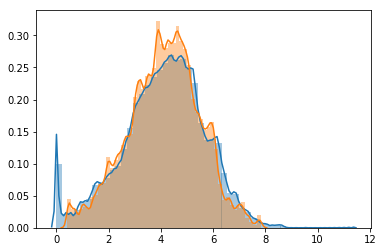

In [38]:
target_meter = 0
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])
gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models0 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols,
                                        num_rounds=1000, lr=0.05, bf=0.7)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models0.append(model)
    gc.collect()
    if debug:
        break

sns.distplot(y_train)
sns.distplot(y_pred_valid)
del X_train, y_train
gc.collect()

In [39]:
def plot_feature_importance(model):
    importance_df = pd.DataFrame(model.feature_importance(),
                                 index=feature_cols + category_cols,
                                 columns=['importance']).sort_values('importance')
    fig, ax = plt.subplots(figsize=(8, 8))
    importance_df.plot.barh(ax=ax)
    fig.show()

target_meter 1 (4182772, 41)
cat_features [38, 39, 40]
train 3346217 valid 836555
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 2.41543	valid_1's l2: 2.82733
[40]	training's l2: 1.71022	valid_1's l2: 1.95107
[60]	training's l2: 1.41728	valid_1's l2: 1.76605
[80]	training's l2: 1.2612	valid_1's l2: 1.71903
[100]	training's l2: 1.1665	valid_1's l2: 1.70393
[120]	training's l2: 1.0898	valid_1's l2: 1.69977
[140]	training's l2: 1.04268	valid_1's l2: 1.69449
Early stopping, best iteration is:
[139]	training's l2: 1.04536	valid_1's l2: 1.69299
best_score defaultdict(<class 'dict'>, {'training': {'l2': 1.0453642074483278}, 'valid_1': {'l2': 1.6929911099166097}})
train 3346217 valid 836555
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 2.39924	valid_1's l2: 2.41823
[40]	training's l2: 1.6579	valid_1's l2: 1.84722
[60]	training's l2: 1.38725	valid_1's l2: 1.69548
[80]	training's l2: 1.2561	valid_1

15

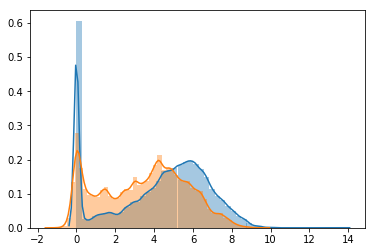

In [40]:
target_meter = 1
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])
gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models1 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols, num_rounds=1000,
                                       lr=0.05, bf=0.5)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models1.append(model)
    gc.collect()
    if debug:
        break

sns.distplot(y_train)
sns.distplot(y_pred_valid)
del X_train, y_train
gc.collect()

target_meter 2 (2708966, 41)
cat_features [38, 39, 40]
train 2167172 valid 541794
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 2.59794	valid_1's l2: 3.25396
[40]	training's l2: 1.85121	valid_1's l2: 2.67437
[60]	training's l2: 1.56995	valid_1's l2: 2.59142
Early stopping, best iteration is:
[57]	training's l2: 1.60592	valid_1's l2: 2.58207
best_score defaultdict(<class 'dict'>, {'training': {'l2': 1.6059172777264612}, 'valid_1': {'l2': 2.582074329427261}})
train 2167173 valid 541793
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 2.56553	valid_1's l2: 2.88548
[40]	training's l2: 1.81972	valid_1's l2: 2.34011
[60]	training's l2: 1.56309	valid_1's l2: 2.19815
[80]	training's l2: 1.43849	valid_1's l2: 2.14105
[100]	training's l2: 1.36504	valid_1's l2: 2.09055
[120]	training's l2: 1.3067	valid_1's l2: 2.05458
[140]	training's l2: 1.26134	valid_1's l2: 2.03117
[160]	training's l2: 1.22357	vali

15

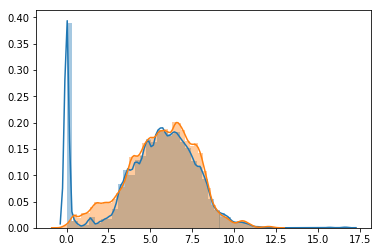

In [41]:
target_meter = 2
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])

gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models2 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols,
                                        num_rounds=1000, lr=0.05, bf=0.8)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models2.append(model)
    gc.collect()
    if debug:
        break

sns.distplot(y_train)
sns.distplot(y_pred_valid)
del X_train, y_train
gc.collect()

target_meter 3 (1264125, 41)
cat_features [38, 39, 40]
train 1011300 valid 252825
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 3.52475	valid_1's l2: 4.27841
[40]	training's l2: 2.51289	valid_1's l2: 3.16894
[60]	training's l2: 2.09975	valid_1's l2: 2.74357
[80]	training's l2: 1.91128	valid_1's l2: 2.55983
[100]	training's l2: 1.79361	valid_1's l2: 2.47644
[120]	training's l2: 1.71311	valid_1's l2: 2.43064
[140]	training's l2: 1.64119	valid_1's l2: 2.40783
[160]	training's l2: 1.58213	valid_1's l2: 2.38146
[180]	training's l2: 1.5383	valid_1's l2: 2.37747
Early stopping, best iteration is:
[178]	training's l2: 1.54227	valid_1's l2: 2.37737
best_score defaultdict(<class 'dict'>, {'training': {'l2': 1.5422698372825052}, 'valid_1': {'l2': 2.3773728801871674}})
train 1011300 valid 252825
training LGB:
Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 3.49982	valid_1's l2: 3.67607
[40]	training's l2: 2.42467	v

15

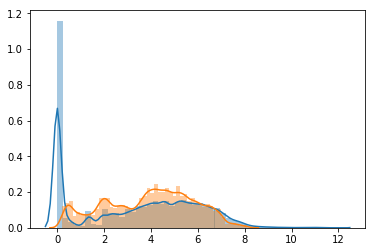

In [42]:
target_meter = 3
X_train, y_train = create_X_y(train_df, target_meter=target_meter)
y_valid_pred_total = np.zeros(X_train.shape[0])

gc.collect()
print('target_meter', target_meter, X_train.shape)

cat_features = [X_train.columns.get_loc(cat_col) for cat_col in category_cols]
print('cat_features', cat_features)

models3 = []
for train_idx, valid_idx in kf.split(X_train, y_train):
    train_data = X_train.iloc[train_idx,:], y_train[train_idx]
    valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

    print('train', len(train_idx), 'valid', len(valid_idx))
#     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
    model, y_pred_valid, log = fit_lgbm(train_data, valid_data, cat_features=category_cols, num_rounds=1000,
                                       lr=0.03, bf=0.9)
    y_valid_pred_total[valid_idx] = y_pred_valid
    models3.append(model)
    gc.collect()
    if debug:
        break

sns.distplot(y_train)
sns.distplot(y_pred_valid)
del X_train, y_train
gc.collect()

# Prediction on test data

In [43]:
print('loading...')
test_df = pd.read_csv(root/'test.csv')
weather_test_df = pd.read_csv(root/'weather_test_tz_fix.csv')

print('preprocessing building...')
test_df['timestamp']=pd.to_datetime(test_df['timestamp'])
weather_test_df['timestamp']=pd.to_datetime(weather_test_df['timestamp'])
test_df['date'] = test_df['timestamp'].dt.date

weather_test_df['date'] = weather_test_df['timestamp'].dt.date
weather_test_df=weather_test_df.merge(nasa_weather_df, on=['site_id', 'date'], how='left')
weather_test_df.drop(columns='date',inplace=True)

preprocess(test_df)
test_df['building_mean'] = test_df['building_id'].map(building_mean)
test_df['building_median'] = test_df['building_id'].map(building_median)
test_df['building_min'] = test_df['building_id'].map(building_min)
test_df['building_max'] = test_df['building_id'].map(building_max)
test_df['building_std'] = test_df['building_id'].map(building_std)

print('preprocessing weather...')
weather_test_df = weather_test_df.groupby('site_id').apply(lambda group: group.interpolate(limit_direction='both'))
weather_test_df.groupby('site_id').apply(lambda group: group.isna().sum())

add_lag_feature(weather_test_df, window=3)
add_lag_feature(weather_test_df, window=72)

print('reduce mem usage...')
reduce_mem_usage(test_df, use_float16=True)
reduce_mem_usage(weather_test_df, use_float16=True)

gc.collect()

loading...
preprocessing building...
preprocessing weather...
reduce mem usage...
Memory usage of dataframe is 3260.81 MB
Memory usage after optimization is: 1232.77 MB
Decreased by 62.2%
Memory usage of dataframe is 67.69 MB
Memory usage after optimization is: 42.04 MB
Decreased by 37.9%


874

In [44]:
sample_submission = pd.read_csv(os.path.join(root, 'sample_submission.csv'))
reduce_mem_usage(sample_submission)

Memory usage of dataframe is 636.25 MB
Memory usage after optimization is: 198.83 MB
Decreased by 68.7%


,row_id,meter_reading
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
5,5,0
6,6,0
7,7,0
8,8,0
9,9,0


In [57]:
test_df.meter.value_counts()

0    24755760
1     8724960
2     5676480
3     2540400
Name: meter, dtype: int64

In [71]:
target_test_df = test_df[test_df['meter'] == 0]
print(target_test_df.shape)
target_test_df = target_test_df.merge(building_meta_df, on='building_id', how='left')
ind_lst1=target_test_df.index
print(target_test_df.shape)
target_test_df = target_test_df.merge(weather_test_df, on=['site_id', 'timestamp'], how='left')
print(target_test_df.shape)
ind_lst2=target_test_df.index

(24755760, 14)
(24755760, 19)
(24758316, 90)


In [78]:
inx=(set(ind_lst2) - set(ind_lst1))

In [80]:
target_test_df.loc[inx]

,row_id,building_id,meter,timestamp,date,hour,weekend,month,dayofweek,building_mean,...,sea_level_pressure_min_lag72,sea_level_pressure_std_lag72,wind_direction_mean_lag72,wind_direction_max_lag72,wind_direction_min_lag72,wind_direction_std_lag72,wind_speed_mean_lag72,wind_speed_max_lag72,wind_speed_min_lag72,wind_speed_std_lag72
24756224,41692244,1344,0,2018-11-14 08:00:00,2018-11-14,8,2,11,2,4.878906,...,1016.5,3.863281,189.500,350.0,0.0,105.9375,3.261719,10.796875,0.0,2.207031
24756225,41692247,1345,0,2018-11-14 08:00:00,2018-11-14,8,2,11,2,3.292969,...,1016.5,3.863281,189.500,350.0,0.0,105.9375,3.261719,10.796875,0.0,2.207031
24756226,41692250,1346,0,2018-11-14 08:00:00,2018-11-14,8,2,11,2,1.649414,...,1016.5,3.863281,189.500,350.0,0.0,105.9375,3.261719,10.796875,0.0,2.207031
24756227,41692252,1347,0,2018-11-14 08:00:00,2018-11-14,8,2,11,2,6.152344,...,1016.5,3.863281,189.500,350.0,0.0,105.9375,3.261719,10.796875,0.0,2.207031
24756228,41692255,1348,0,2018-11-14 08:00:00,2018-11-14,8,2,11,2,5.843750,...,1016.5,3.863281,189.500,350.0,0.0,105.9375,3.261719,10.796875,0.0,2.207031
24756229,41692259,1350,0,2018-11-14 08:00:00,2018-11-14,8,2,11,2,4.304688,...,1016.5,3.863281,189.500,350.0,0.0,105.9375,3.261719,10.796875,0.0,2.207031
24756230,41692262,1351,0,2018-11-14 08:00:00,2018-11-14,8,2,11,2,3.369141,...,1016.5,3.863281,189.500,350.0,0.0,105.9375,3.261719,10.796875,0.0,2.207031
24756231,41692265,1352,0,2018-11-14 08:00:00,2018-11-14,8,2,11,2,4.183594,...,1016.5,3.863281,189.500,350.0,0.0,105.9375,3.261719,10.796875,0.0,2.207031
24756232,41692267,1353,0,2018-11-14 08:00:00,2018-11-14,8,2,11,2,2.003906,...,1016.5,3.863281,189.500,350.0,0.0,105.9375,3.261719,10.796875,0.0,2.207031
24756233,41692270,1355,0,2018-11-14 08:00:00,2018-11-14,8,2,11,2,3.773438,...,1016.5,3.863281,189.500,350.0,0.0,105.9375,3.261719,10.796875,0.0,2.207031


In [70]:
target_test_df[target_test_df['ALLSKY_TOA_SW_DWN'].isna()]

,row_id,building_id,meter,timestamp,date,hour,weekend,month,dayofweek,building_mean,...,sea_level_pressure_min_lag72,sea_level_pressure_std_lag72,wind_direction_mean_lag72,wind_direction_max_lag72,wind_direction_min_lag72,wind_direction_std_lag72,wind_speed_mean_lag72,wind_speed_max_lag72,wind_speed_min_lag72,wind_speed_std_lag72
176610,216978,0,0,2017-03-12 02:00:00,2017-03-12,2,6,3,6,5.433594,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176611,216979,1,0,2017-03-12 02:00:00,2017-03-12,2,6,3,6,4.761719,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176612,216980,2,0,2017-03-12 02:00:00,2017-03-12,2,6,3,6,2.998047,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176613,216981,3,0,2017-03-12 02:00:00,2017-03-12,2,6,3,6,5.875000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176614,216982,4,0,2017-03-12 02:00:00,2017-03-12,2,6,3,6,7.343750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176615,216983,5,0,2017-03-12 02:00:00,2017-03-12,2,6,3,6,3.230469,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176616,216984,6,0,2017-03-12 02:00:00,2017-03-12,2,6,3,6,4.593750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176617,216985,7,0,2017-03-12 02:00:00,2017-03-12,2,6,3,6,6.875000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176618,216987,8,0,2017-03-12 02:00:00,2017-03-12,2,6,3,6,6.007812,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176619,216988,9,0,2017-03-12 02:00:00,2017-03-12,2,6,3,6,4.851562,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
def create_X(test_df, target_meter):
    target_test_df = test_df[test_df['meter'] == target_meter]
    target_test_df = target_test_df.merge(building_meta_df, on='building_id', how='left')
    target_test_df = target_test_df.merge(weather_test_df, on=['site_id', 'timestamp'], how='left')
    X_test = target_test_df[feature_cols + category_cols]
    return X_test

In [46]:
def pred(X_test, models, batch_size=1000000):
    iterations = (X_test.shape[0] + batch_size -1) // batch_size
    print('iterations', iterations)
    print('samples', X_test.shape[0])

    y_test_pred_total = np.zeros(X_test.shape[0])
    for i, model in enumerate(models):
        print(f'predicting {i}-th model')
        for k in tqdm(range(iterations)):
            y_pred_test = model.predict(X_test[k*batch_size:(k+1)*batch_size], num_iteration=model.best_iteration)
            y_test_pred_total[k*batch_size:(k+1)*batch_size] += np.expm1(y_pred_test)

    y_test_pred_total /= len(models)
    print('y_samples',y_test_pred_total.shape[0])
    return y_test_pred_total


iterations 25
samples 24758316
predicting 0-th model



predicting 1-th model



predicting 2-th model



predicting 3-th model



predicting 4-th model



y_samples 24758316


299

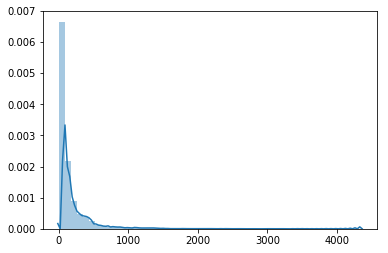

In [47]:
#%%time
X_test = create_X(test_df, target_meter=0)
gc.collect()

y_test0 = pred(X_test, models0)

sns.distplot(y_test0)

del X_test
gc.collect()

iterations 9
samples 8725758
predicting 0-th model



predicting 1-th model



predicting 2-th model



predicting 3-th model



predicting 4-th model



y_samples 8725758


64

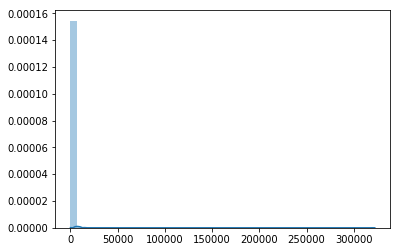

In [48]:
#%%time
X_test = create_X(test_df, target_meter=1)
gc.collect()

y_test1 = pred(X_test, models1)
sns.distplot(y_test1)

del X_test
gc.collect()

iterations 6
samples 5677128
predicting 0-th model



predicting 1-th model



predicting 2-th model



predicting 3-th model



predicting 4-th model



y_samples 5677128


250

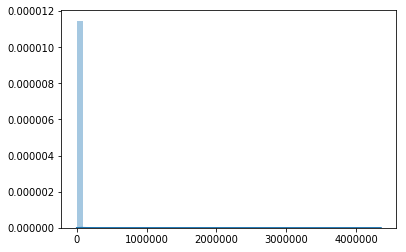

In [49]:
#%%time
X_test = create_X(test_df, target_meter=2)
gc.collect()

y_test2 = pred(X_test, models2)
sns.distplot(y_test2)

del X_test
gc.collect()

iterations 3
samples 2540580
predicting 0-th model



predicting 1-th model



predicting 2-th model



predicting 3-th model



predicting 4-th model



y_samples 2540580


111

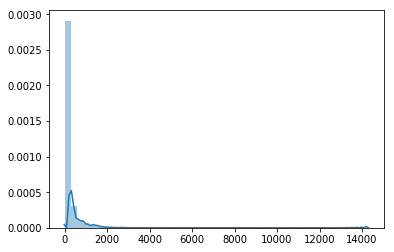

In [50]:
X_test = create_X(test_df, target_meter=3)
gc.collect()

y_test3 = pred(X_test, models3)
sns.distplot(y_test3)

del X_test
gc.collect()

In [51]:
(test_df['meter'] == 0).sum()

24755760

In [52]:
sample_submission.loc[test_df['meter'] == 0, 'meter_reading'] = y_test0
sample_submission.loc[test_df['meter'] == 1, 'meter_reading'] = y_test1
sample_submission.loc[test_df['meter'] == 2, 'meter_reading'] = y_test2
sample_submission.loc[test_df['meter'] == 3, 'meter_reading'] = y_test3
sample_submission['meter_reading'].clip(lower=0, inplace=True)

ValueError: Must have equal len keys and value when setting with an iterable

In [ ]:
sample_submission.to_csv('submission.csv', index=False, float_format='%.4f')

In [ ]:
sample_submission.sample(10)

In [ ]:
np.log1p(sample_submission['meter_reading']).hist()

In [ ]:
plot_feature_importance(models0[1])

In [ ]:
plot_feature_importance(models1[1])

In [ ]:
plot_feature_importance(models2[1])

In [ ]:
plot_feature_importance(models3[1])

# References

These kernels inspired me to write this kernel, thank you for sharing!

 - https://www.kaggle.com/rishabhiitbhu/ashrae-simple-eda
 - https://www.kaggle.com/isaienkov/simple-lightgbm
 - https://www.kaggle.com/ryches/simple-lgbm-solution